# Install Torch

In [1]:
torchver = "0.4.0"

In [2]:
!/opt/bin/nvidia-smi || /usr/bin/nvidia-smi

/bin/sh: 1: /opt/bin/nvidia-smi: not found
Mon Jun  4 18:09:45 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.25                 Driver Version: 390.25                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980     Off  | 00000000:01:00.0  On |                  N/A |
| 18%   59C    P8    16W / 185W |    226MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                 

In [3]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [4]:
!pip3 uninstall -y pillow
!CC="cc -mavx2" pip3 install -U --force-reinstall pillow-simd


Skipping pillow as it is not installed.
scikit-image 0.13.1 requires pillow>=2.1.0, which is not installed.
fastai 0.7.0 requires Pillow, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
tensorflow 1.7.0 has requirement tensorboard<1.8.0,>=1.7.0, but you'll have tensorboard 1.8.0 which is incompatible.
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.0 which is incompatible.
django-haystack 2.8.1 has requirement Django>=1.11, but you'll have django 1.7.11 which is incompatible.
  Found existing installation: Pillow-SIMD 5.1.1.post0
    Uninstalling Pillow-SIMD-5.1.1.post0:
      Successfully uninstalled Pillow-SIMD-5.1.1.post0


In [5]:

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

pver = !python --version |& awk '{print $2 }' | awk -F. '{ print $1$2}'
pyver = pver[0]
print(pyver)

# cver = !echo "cu`nvcc --version | sed "s/ /\n/g" | grep -i release -A 1 | tail -n 1 | tr -d [\.,]`"
# cudaver = cver[0]
cudaver = 'cu91'

# accelerator =  cudaver if path.exists('/opt/bin/nvidia-smi') or path.exists('/usr/bin/nvidia-smi') else 'cpu'
# print(accelerator)

# torchurl = "http://download.pytorch.org/whl/{0}/torch-{1}-cp{2}-cp{2}m-linux_x86_64.whl".format(accelerator, torchver, pyver)
# print(torchurl)

# !pip3 install http://download.pytorch.org/whl/cu91/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision

import torch
import torchvision
print(torchvision.get_image_backend())

36
PIL


# Imports

In [6]:
import numpy as np
import torch
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace
from collections import OrderedDict
from scipy.sparse import coo_matrix
import socket
from datetime import datetime
import json
import re
import hashlib
import subprocess
from copy import deepcopy, copy
from pprint import pprint
import torch.utils.data as data
from copy import copy
import json
from collections import namedtuple
from PIL import Image 
from torchvision import get_image_backend
from torch.utils.data.distributed import DistributedSampler
import torch.nn.init as weight_init
import csv
import PIL
import ipdb

In [7]:
%matplotlib inline

# Parameters

In [8]:
def get_hostname_timestamp_id():
    return socket.gethostname() + '_' + re.sub(r'\W+', '', str(datetime.now()))

In [9]:
def get_output_fname():
    return "%s_%s_%s" % (args.author, args.arch, get_hostname_timestamp_id())

In [10]:
args = Namespace()
args.perm_dir = '/mnt/disks/imaterialist_fashion'
args.base_dir = '/mnt/ram-disk/imaterialist_fashion'
args.data_dir = args.base_dir + os.sep + 'data_ifood'
args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'
args.train_dir = args.input_dir + os.sep + 'train_set'
args.val_dir = args.input_dir + os.sep + 'val_set'
args.test_dir = args.input_dir + os.sep + 'test_set'
# args.train_labels_csv = args.input_dir + os.sep + 'train_info.csv'
# args.train_labels_csv = args.input_dir + os.sep + 'train_small_info.csv' 
args.train_labels_csv = args.input_dir + os.sep + 'train_tiny_info.csv' 
args.val_labels_csv = args.input_dir + os.sep + 'val_info.csv'
args.test_labels_csv = args.input_dir + os.sep + 'test_info.csv'
args.debug_weights = False
args.test_overfit = False
args.num_labels = 211
args.batch_size = 16
# args.batch_size = 64
args.image_min_size = 256
args.nw_input_size = 224
args.num_workers = 4
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std
args.world_size = 1
args.dist_url = 'file://' + args.output_dir + os.sep + 'dfile'
args.dist_backend = 'gloo'
args.distributed = args.world_size > 1
args.arch = 'resnet101'
# args.arch = 'resnet152'
args.fv_size = 2048
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-4      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 10
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)
args.best = args.ckpt_dir + os.sep + 'best_%s.pth.tar' % (args.arch,)
args.num_output_labels = 3
args.sub_dir = args.output_dir + os.sep + 'submissions'
args.author = 'deccanlearners'
args.output_id = get_output_fname()
args.output_file = args.sub_dir + os.sep + 'output_%s.csv' %  args.output_id
args.params_file = args.sub_dir + os.sep + 'params_%s.json' % args.output_id
args.min_img_bytes = 4792

In [11]:
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


7102
True
GeForce GTX 980


In [12]:
cudnn.benchmark = True

In [13]:
def mkdir_p(d):
    os.makedirs(d, exist_ok=True)

def sha1_hash(fname, blocksize=4096):
    """ compute sha1hash of a file """
    hash = ''
    if not os.path.exists(fname):
        errmsg = "File %s does not exist" % (fname)
        print(errmsg)
        return ''
    try:
        hasher = hashlib.sha1()
        with open(fname, 'rb') as f:
            buf = f.read(blocksize)
            while len(buf) > 0:
                hasher.update(buf)
                buf = f.read(blocksize)
        hash = hasher.hexdigest()
    except:
        print("Exception in hashing file")
        raise
    return hash


def rsync_and_verify(src, dst, verify=False, max_attempts=1):
    """Rsync src to dst and verify if copy is done"""

    print('Rsync %s to %s on %s\n' % (src,
                                      dst,
                                      socket.gethostname()))
    sys.stdout.flush()
    src_ = deepcopy(src)
    dst_ = deepcopy(dst)
    src_cred = ''
    src_path = ''
    dst_cred = ''
    dst_path = ''
    rsync_path = ''

    if ':' in src:
        src_cred, src_path = src.split(':')
    else:
        src_cred = ''
        src_path = src

    if ':' in dst:
        dst_cred, dst_path = dst.split(':')
    else:
        dst_cred = ''
        dst_path = dst

    if src_cred == '':
        mkdir_p(src_path)
    else:
        rsync_path = '--rsync-path=' + '"' + 'mkdir -p' + ' ' + src_path + ' ' + '&&' + ' ' + 'rsync --copy-links' + '"'
    
    if dst_cred == '':
        mkdir_p(dst_path)
    else:
        rsync_path = '--rsync-path=' + '"' + 'mkdir -p' + ' ' + src_path + ' ' + '&&' + ' ' + 'rsync --copy-links' + '"'

    if src_[-1] != os.sep:
        src_ = src_ + os.sep
    
    if dst_[-1] != os.sep:
        dst_ = dst_ + os.sep

    for attempt in range(max_attempts):
        print('attempt %d' % attempt)
        try:
            copycmd = 'rsync -a --copy-links' + ' ' + rsync_path + ' ' + src_ + ' ' + dst_ 
            pprint(copycmd)
            sys.stdout.flush()
            output = subprocess.check_output(copycmd,
                                             shell=True)
            pprint(output)
            sys.stdout.flush()

            if verify:
                # Verify if the copying is done correctly
                if os.path.isdir(src):
                    for fl in os.listdir(src):
                        sfile = src + os.sep + fl
                        dfile = dst + os.sep + fl
                        shash = sha1_hash(sfile)
                        dhash = sha1_hash(dfile)
                        if shash != dhash:
                            print('Hashes of files %s and %s do not match.' % (sfile, dfile))
                            print('Error in copying. Quitting ...\n')
                            sys.stdout.flush()
                            raise Exception('hash mismatch')
                        print('.', end='')
                        sys.stdout.flush()
                else:
                    shash = sha1_hash(src)
                    dhash = sha1_hash(dst)
                    if shash != dhash:
                        print('Hashes of files %s and %s do not match.' % (src, dst))
                        print('Error in copying. Quitting ...\n')
                        sys.stdout.flush()
                        raise Exception('hash mismatch')
                print('Hash check passed')
                sys.stdout.flush()

            break    # break if successful
        # except Exception, arg:
        except:
            # print('Error:', arg)
            print('Error in rsync')
            pass     # else retry


In [14]:
os.makedirs(args.base_dir, exist_ok=True)
os.makedirs(args.data_dir, exist_ok=True)
os.makedirs(args.input_dir, exist_ok=True)
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(args.ckpt_dir, exist_ok=True)
os.makedirs(args.sub_dir, exist_ok=True)

In [15]:
rsync_and_verify(args.perm_dir, args.base_dir)

Rsync /mnt/disks/imaterialist_fashion to /mnt/ram-disk/imaterialist_fashion on sourabhd-desktop

attempt 0
('rsync -a --copy-links  /mnt/disks/imaterialist_fashion/ '
 '/mnt/ram-disk/imaterialist_fashion/')
b''


# Dataset

In [16]:
import torch.utils.data as data
from copy import copy
import numpy as np


def parse_info(infofile, indir, istest=False, num_labels=211):
  with open(infofile) as f:
    dr = csv.DictReader(f, fieldnames=['fname']) if istest else csv.DictReader(f, fieldnames=['fname', 'labelId'])
    I = OrderedDict()
    L = None if istest else OrderedDict()
    for d in dr:
        fname = d['fname']
        imageid = int(fname.split('_')[-1].split('.')[0])
        I[imageid] = copy(os.path.join(indir, fname))
        if not istest:
            L[imageid] = np.zeros((num_labels,), dtype=np.float32)
            L[imageid][int(d['labelId'])] = 1.0  # single label dataset
    return (I, L)

def get_labelinfo(labels):
  from collections import namedtuple
  labelinfo = namedtuple('labelinfo', "set min max count")
  labelinfo.set = set()
  for k, v in labels.items():
    labelinfo.set.update([v])
  labelinfo.min = min(labelinfo.set)
  labelinfo.max = max(labelinfo.set)
  labelinfo.count = len(labelinfo.set)
  return labelinfo

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def pil_loader(path):
    from PIL import Image 
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

      
class FoodDataset(data.Dataset):
  """Food dataset CVPR challenge.
     Adapted from torchvision ImageFolder.
     Similar to ImageFolder with the following differences:
     1. Multilabel
     2. Directory structure where all images are directly in the root folder
     3. Labels are read from json file
   
  Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
    
  """

  def __init__(self, root, metadata_file, num_labels=211, transform=None, target_transform=None,
               loader=default_loader, test=False, min_img_bytes=4792):
    sys.stdout.flush()
    extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']
    self.test = test
    self.root = root
    self.num_labels = num_labels
    self.images_ = OrderedDict()
    self.images = OrderedDict()
    self.labels_ = OrderedDict()
    self.labels = OrderedDict()
    
    self.metadata_file = metadata_file
    self.images_, self.labels_ = parse_info(self.metadata_file, root, istest=self.test, num_labels=args.num_labels)
    self.transform = transform
    self.target_transform = target_transform
    self.loader = loader
    self.corrupt = 0
    self.corrupt_ids = set()
     
    # Remove corrupt image files
    ids = self.images_.keys()
#     for i in tqdm(ids):
#         ## Correct but slow
#         try:
#             img = self.loader(self.images_[i])
#             img.close()
#         except:
#             self.corrupt += 1
#             self.corrupt_ids.add(i)
        ## Optimistic 
#         if os.path.getsize(self.images_[i]) < min_img_bytes:
#             self.corrupt += 1
#             self.corrupt_ids.add(i)
#        pass

    for i in ids:
        if i not in self.corrupt_ids:
            self.images[i] = copy(self.images_[i])
            if not self.test:
                self.labels[i] = copy(self.labels_[i])
    self.image_ids = list(self.images.keys())
    
#     if not self.test:
#         self.labelinfo = get_labelinfo(self.labels)
    
  def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        if not self.test:
            path, target = self.images[self.image_ids[index]], self.labels[self.image_ids[index]]
        else:
            path = self.images[self.image_ids[index]]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if not self.test:
            if self.target_transform is not None:
                target = self.target_transform(target)
        
        if self.test:
            return sample
        else:
            return sample, target

  def __len__(self):
    return len(self.images)
  
  def __repr__(self):
    fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
    fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
    fmt_str += '    Number of corrupt datapoints discarded: {}\n'.format(self.corrupt)
#     if not self.test:
#         fmt_str += '    Number of labels: {}\n'.format(self.labelinfo.count)
    fmt_str += '    Root Location: {}\n'.format(self.root)
    fmt_str += '    Metadata file: {}\n'.format(self.metadata_file)
    tmp = '    Transforms (if any): '
    fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    if not self.test:
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
    tmp = '    Loader: '
    fmt_str += '\n{0}{1}'.format(tmp, self.loader.__name__)
    return fmt_str

  

In [17]:
import torchvision.transforms as transforms

def create_transforms(args):
    train_tform = None
    if args.test_overfit:
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                               std=args.pretrain_dset_std)
                                         ])
    else:
        train_tform = transforms.Compose([transforms.RandomResizedCrop(args.image_min_size,
                                                                       scale=(1.0, 1.0),
#                                                                        scale=(0.08, 1.0),
#                                                                        ratio=(3. / 4., 4. / 3.),
#                                                                        ratio=(float(args.nw_input_size) / float(args.image_min_size),
#                                                                               float(args.image_min_size) / float(args.nw_input_size)
#                                                                              ),
                                                                       ratio=(1.0, 1.0),
                                                                       interpolation=Image.BILINEAR
                                                                      ),
#         train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
#                                           transforms.RandomHorizontalFlip(),
#                                           transforms.RandomAffine(90,
#                                                                   translate=(0.25, 0.25),
#                                                                   scale=(3. /4., 4. / 3.),
#                                                                   shear=20,
#                                                                   resample=PIL.Image.BILINEAR,
#                                                                   fillcolor=0),
                                          transforms.CenterCrop(args.nw_input_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                               std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [18]:
train_tform, val_tform = create_transforms(args)
print(train_tform)
print(val_tform)

Compose(
    RandomResizedCrop(size=(256, 256), scale=(1.0, 1.0), ratio=(1.0, 1.0), interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [19]:
train_dset = FoodDataset(args.train_dir, args.train_labels_csv, args.num_labels, transform=train_tform, min_img_bytes=args.min_img_bytes)
val_dset = FoodDataset(args.val_dir, args.val_labels_csv, args.num_labels, transform=val_tform, min_img_bytes=args.min_img_bytes)
test_dset = FoodDataset(args.test_dir, args.test_labels_csv, args.num_labels, transform=val_tform, test=True, min_img_bytes=args.min_img_bytes) # same transform as validation


print(train_dset)
print(val_dset)
print(test_dset)

Dataset FoodDataset
    Number of datapoints: 100
    Number of corrupt datapoints discarded: 0
    Root Location: /mnt/ram-disk/imaterialist_fashion/data_ifood/input/train_set
    Metadata file: /mnt/ram-disk/imaterialist_fashion/data_ifood/input/train_tiny_info.csv
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(256, 256), scale=(1.0, 1.0), ratio=(1.0, 1.0), interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
    Loader: default_loader
Dataset FoodDataset
    Number of datapoints: 10323
    Number of corrupt datapoints discarded: 0
    Root Location: /mnt/ram-disk/imaterialist_fashion/data_ifood/input/val_set
    Metadata file: /mnt/ram-disk/imaterialist_fashion/data_ifood/input/val_info.csv
    Transforms (if an

In [20]:
def tensor_to_numpy(t, avg, std):
  return (255.0 * (np.transpose(np.asarray(t), (1, 2, 0)) * std + avg)).astype(np.uint8)
  

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


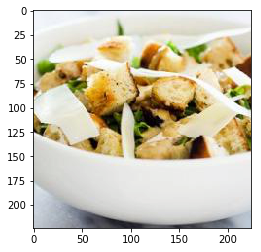

In [21]:
rnd1 = np.random.randint(len(train_dset))
im1, lbl1 = train_dset[rnd1]
imshow(tensor_to_numpy(im1, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


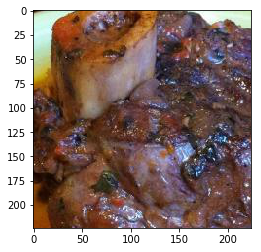

In [22]:
rnd2 = np.random.randint(len(val_dset))
im2, lbl2 = val_dset[rnd2]
imshow(tensor_to_numpy(im2, args.pretrain_dset_mean, args.pretrain_dset_std))
print(lbl2)

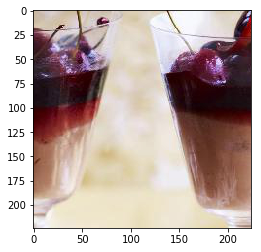

In [23]:
rnd3 = np.random.randint(len(test_dset))
im3 = test_dset[rnd3]
imshow(tensor_to_numpy(im3, args.pretrain_dset_mean, args.pretrain_dset_std))


# DataLoader

In [24]:
if args.distributed:
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url,
                            world_size=args.world_size)


In [25]:
from torch.utils.data.distributed import DistributedSampler 


if args.distributed:
  train_sampler = DistributedSampler(train_dset)
else:
  train_sampler = None

train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=(train_sampler is None),
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                           sampler=train_sampler
                                          )

val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )

test_loader = torch.utils.data.DataLoader(test_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )



In [26]:
# train_images, train_labels = next(iter(train_loader))

In [27]:
# rnd11 = np.random.randint(args.batch_size)
# print(train_images[rnd11,:,:,:])
# print(train_labels[rnd11, :])

In [28]:
# val_images, val_labels = next(iter(val_loader))

In [29]:
# rnd21 = np.random.randint(args.batch_size)
# print(val_images[rnd21,:,:,:])
# print(val_labels[rnd21, :])


# Model

In [30]:
import torch.nn.init as weight_init


class FCWithLogSigmoid(nn.Module):
  
  def __init__(self, num_inputs, num_outputs):
    super(FCWithLogSigmoid, self).__init__()
    self.linear = nn.Linear(num_inputs, num_outputs)
    self.logsigmoid = nn.LogSigmoid()
    
  def forward(self, x):
    return self.logsigmoid(self.linear(x))


def create_model(arch, num_labels=228, fv_size=2048, pretrained=True, resume=False, distributed=False):
  if pretrained:
      print("=> using pre-trained model '{}'".format(arch))
      model = models.__dict__[arch](pretrained=True)
  else:
      print("=> creating model '{}'".format(arch))
      model = models.__dict__[arch]()
  model.fc = FCWithLogSigmoid(fv_size, num_labels)
  if not distributed:
      if arch.startswith('alexnet') or arch.startswith('vgg'):
          model.features = torch.nn.DataParallel(model.features)
          model.cuda()
      else:
          model = torch.nn.DataParallel(model).cuda()
  else:
      model.cuda()
      model = torch.nn.parallel.DistributedDataParallel(model)
  return model


In [31]:
def count_parameters(model):
  """source: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [32]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,
                     distributed=args.distributed)

=> using pre-trained model 'resnet101'


In [33]:
print("Neural Network has ", count_parameters(model), " trainable parameters")

Neural Network has  42932499  trainable parameters


In [34]:
class WeightUpdateTracker:
    
    def __init__(self, model):
        with torch.no_grad():
            self.num_param_tensors = len(list(model.parameters()))
            self.prev_pnorms = torch.zeros(self.num_param_tensors) 
            self.curr_pnorms = self.parameter_norms(model) 

    def parameter_norms(self, model):
        with torch.no_grad():
            pnorms = torch.zeros(self.num_param_tensors)
            for i, x in enumerate(list(model.parameters())):
                pnorms[i] = x.norm().item()
            return pnorms
        
    def track(self, model):
        with torch.no_grad():
            self.prev_pnorms = self.curr_pnorms.clone()
            self.curr_pnorms = self.parameter_norms(model)
            self.delta = (self.curr_pnorms - self.prev_pnorms) / self.prev_pnorms

            
    def __repr__(self):
        with torch.no_grad():
            return self.delta.__repr__()
        

# Loss Function


In [35]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Update Rule

In [36]:
optimizer = optim.Adam(model.parameters(),
                       amsgrad=True,
                       lr=args.optimizer_learning_rate,
                       betas=(0.9, 0.999),
                       eps=1e-8,
                       weight_decay=0.0
                      )
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                           mode='max',   # F1 measure
                                           patience=args.scheduler_patience,
                                           threshold=args.scheduler_threshold,
                                           factor=args.scheduler_factor,
                                           verbose=1
                                          )


# Training Loop


In [37]:
def load_checkpoint(model, optimizer, scheduler, args, resume=True, ckpt=None):
    """optionally resume from a checkpoint."""
    best_f1 = 0
    if args.resume:
        if os.path.isfile(ckpt):
            print("=> loading checkpoint '{}'".format(ckpt))
            checkpoint = torch.load(ckpt)
            args.start_epoch = checkpoint['epoch']
            best_f1 = checkpoint['best_f1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
          #  scheduler.load_state_dict(checkpoint['scheduler'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(ckpt))
            best_f1 = 0
    return (model, optimizer, scheduler, args, best_f1)

In [38]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', best_model_filename='model_best.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, best_model_filename)

In [39]:
class F1MicroAverageMeter(object):
    """Computes and stores F1 store"""
    def __init__(self, threshold=0.5, small=1e-12):
        self.threshold = threshold
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            fake = 1.0 - real
            pos = pred.ge(self.threshold)
            pos = pos.float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [40]:
class F1MicroAverageMeterByTopK(object):
    """Computes and stores F1 store"""
    def __init__(self, k=3, small=1e-12):
        self.k = k
        self.small = small
        self.reset()

    def reset(self):
        self.TP = 0.0
        self.FP = 0.0
        self.FN = 0.0
        self.TN = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.f1 = 0.0

    def update(self, labels, pred):
        tp, fp, fn, tn = self.confusion_matrix_(labels, pred)
        self.TP += tp
        self.FP += fp
        self.FN += fn
        self.TN += tn
        self.precision = self.TP / (self.small + self.TP + self.FP)
        self.recall = self.TP / (self.small + self.TP + self.FN)
        self.f1 = (2.0 * self.precision * self.recall) / (self.small + self.precision + self.recall)
        
    def confusion_matrix_(self, labels, pred):
        with torch.no_grad():
            real = labels
            threshold = pred.topk(self.k)[0].min()
            fake = 1.0 - real
            pos = pred.ge(threshold)
            pos = pos.float()
            neg = 1.0 - pos
            tp = torch.sum(real * pos).item()
            fp = torch.sum(fake * pos).item()
            fn = torch.sum(real * neg).item()
            tn = torch.sum(fake * neg).item()
            return (tp, fp, fn, tn)
              

In [41]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [42]:
def adjust_learning_rate(optimizer, scheduler, epoch, measure, args):
    if not args.test_overfit:
        scheduler.step(measure)


In [43]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top3 = F1MicroAverageMeterByTopK(k=3)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure F1 and record loss
        losses.update(loss.item(), input.size(0))
        top3.update(target, torch.exp(output))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {top3.precision:.3f}\t'
                  'Recall {top3.recall:.3f}\t'
                  'F1 {top3.f1:.3f}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top3=top3))

In [44]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top3 = F1MicroAverageMeterByTopK(k=3)

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda(non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure F1 and record loss
            losses.update(loss.item(), input.size(0))
            top3.update(target, torch.exp(output))
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Precision {top3.precision:.3f}\t'
                      'Recall {top3.recall:.3f}\t'
                      'F1 {top3.f1:.3f}'.format(
                       i, len(val_loader), batch_time=batch_time, loss=losses,
                       top3=top3))

        print(' * Precision {top3.precision:.3f} Recall {top3.recall:.3f} F1 {top3.f1:.3f}'
              .format(top3=top3))

    return top3.f1

In [45]:
def test(ofname, pfname, args, test_dset,
         test_loader, best_model_ckpt, model,
         num_output_labels=3, epoch=0):
    
#     checkpoint = torch.load(best_model_ckpt)
#     model.load_state_dict(checkpoint['state_dict'])
    
    batch_time = AverageMeter()
    res = OrderedDict()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, input in enumerate(test_loader):
            # compute output
            output = model(input)
            torch.exp(output).topk(num_output_labels, dim=1)[1].cpu().numpy().tolist()
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                 print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'.format(
                       i, len(test_loader), batch_time=batch_time))
    
    ofname_ = "%s%s%03d_%s" % (os.path.dirname(ofname), os.sep, epoch, os.path.basename(ofname))
    with open(ofname_, "w") as ofd:
        ofd.write("image_id,label_id\n")
        for k, v in res.items():
            ofd.write("%d,%s\n" % (k, " ".join(map(str,v))))
            
    pfname_ = "%s%s%03d_%s" % (os.path.dirname(pfname), os.sep, epoch, os.path.basename(pfname))
    with open(pfname_, "w") as pfd:
        json.dump(vars(args), pfd, sort_keys=True, indent=4)
            
    print("Output written to %s\n" % ofname_)
    print("Program parameters written to %s\n" % pfname_)
    sys.stdout.flush()

In [46]:
def train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, num_output_labels=3):
    if args.evaluate:
        validate(val_loader, model, criterion)
    else:
        model, optimizer, scheduler, args, best_f1 = load_checkpoint(model, optimizer, scheduler, args, resume=args.resume, ckpt=args.ckpt)
        wut = None
        if args.debug_weights:
            wut = WeightUpdateTracker(model)
        for epoch in range(args.start_epoch, args.epochs):
            if args.distributed:
                train_sampler.set_epoch(epoch)
    #         adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            train(train_loader, model, criterion, optimizer, epoch)

            if args.debug_weights:
                # debug: track weight updates
                wut.track(model)
                print(wut)

            # evaluate on validation set
            f1 = validate(val_loader, model, criterion)

            # remember best f1 and save checkpoint
            is_best = f1 > best_f1
            best_f1 = max(f1, best_f1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_f1': best_f1,
                'optimizer' : optimizer.state_dict(),
               # 'scheduler' : scheduler.state_dict(),
            }, is_best, filename=args.ckpt, best_model_filename=args.best)

            if is_best:
                print("BEST: ", epoch)
                sys.stdout.flush()
            adjust_learning_rate(optimizer, scheduler, epoch, f1, args)
            test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, num_output_labels=args.num_output_labels, epoch=epoch)            
            rsync_and_verify(args.base_dir, args.perm_dir)


In [ ]:
train_loop(train_loader, val_loader, test_loader, test_dset, args, optimizer, scheduler, model, criterion, num_output_labels=args.num_output_labels)

Epoch: [0][0/7]	Time 4.483 (4.483)	Data 0.432 (0.432)	Loss 0.4039 (0.4039)	Precision 0.000	Recall 0.000	F1 0.000
Test: [0/646]	Time 0.774 (0.774)	Loss 0.3145 (0.3145)	Precision 0.012	Recall 0.062	F1 0.020
Test: [16/646]	Time 0.098 (0.139)	Loss 0.3129 (0.3153)	Precision 0.005	Recall 0.026	F1 0.008
Test: [32/646]	Time 0.099 (0.119)	Loss 0.3166 (0.3157)	Precision 0.006	Recall 0.032	F1 0.010
Test: [48/646]	Time 0.099 (0.113)	Loss 0.3145 (0.3159)	Precision 0.005	Recall 0.028	F1 0.009
Test: [64/646]	Time 0.099 (0.109)	Loss 0.3137 (0.3157)	Precision 0.006	Recall 0.031	F1 0.010
Test: [80/646]	Time 0.099 (0.107)	Loss 0.3144 (0.3158)	Precision 0.006	Recall 0.031	F1 0.010
Test: [96/646]	Time 0.099 (0.106)	Loss 0.3169 (0.3157)	Precision 0.005	Recall 0.030	F1 0.009
Test: [112/646]	Time 0.099 (0.105)	Loss 0.3185 (0.3156)	Precision 0.006	Recall 0.030	F1 0.009
Test: [128/646]	Time 0.099 (0.104)	Loss 0.3173 (0.3157)	Precision 0.005	Recall 0.029	F1 0.009
Test: [144/646]	Time 0.099 (0.103)	Loss 0.3150 (0

Test: [0/646]	Time 0.562 (0.562)	Loss 0.2024 (0.2024)	Precision 0.010	Recall 0.062	F1 0.017
Test: [16/646]	Time 0.099 (0.126)	Loss 0.2062 (0.2057)	Precision 0.004	Recall 0.029	F1 0.008
Test: [32/646]	Time 0.099 (0.113)	Loss 0.2087 (0.2061)	Precision 0.005	Recall 0.040	F1 0.010
Test: [48/646]	Time 0.099 (0.108)	Loss 0.2055 (0.2069)	Precision 0.004	Recall 0.032	F1 0.008
Test: [64/646]	Time 0.099 (0.106)	Loss 0.2018 (0.2065)	Precision 0.005	Recall 0.037	F1 0.009
Test: [80/646]	Time 0.099 (0.104)	Loss 0.2029 (0.2066)	Precision 0.005	Recall 0.039	F1 0.009
Test: [96/646]	Time 0.098 (0.103)	Loss 0.2108 (0.2066)	Precision 0.005	Recall 0.039	F1 0.009
Test: [112/646]	Time 0.098 (0.103)	Loss 0.2066 (0.2064)	Precision 0.005	Recall 0.037	F1 0.009
Test: [128/646]	Time 0.098 (0.102)	Loss 0.2108 (0.2067)	Precision 0.005	Recall 0.037	F1 0.009
Test: [144/646]	Time 0.098 (0.102)	Loss 0.2047 (0.2066)	Precision 0.005	Recall 0.037	F1 0.009
Test: [160/646]	Time 0.098 (0.101)	Loss 0.1989 (0.2066)	Precision 0.

Test: [32/646]	Time 0.108 (0.119)	Loss 0.1085 (0.1061)	Precision 0.005	Recall 0.057	F1 0.009
Test: [48/646]	Time 0.107 (0.114)	Loss 0.1118 (0.1065)	Precision 0.004	Recall 0.050	F1 0.008
Test: [64/646]	Time 0.108 (0.112)	Loss 0.1055 (0.1063)	Precision 0.005	Recall 0.054	F1 0.009
Test: [80/646]	Time 0.107 (0.110)	Loss 0.1040 (0.1065)	Precision 0.005	Recall 0.059	F1 0.009
Test: [96/646]	Time 0.108 (0.109)	Loss 0.1096 (0.1065)	Precision 0.005	Recall 0.057	F1 0.009
Test: [112/646]	Time 0.107 (0.109)	Loss 0.1060 (0.1064)	Precision 0.005	Recall 0.056	F1 0.009
Test: [128/646]	Time 0.102 (0.108)	Loss 0.1090 (0.1066)	Precision 0.005	Recall 0.057	F1 0.009
Test: [144/646]	Time 0.102 (0.108)	Loss 0.1002 (0.1065)	Precision 0.005	Recall 0.056	F1 0.009
Test: [160/646]	Time 0.103 (0.108)	Loss 0.1033 (0.1066)	Precision 0.005	Recall 0.056	F1 0.009
Test: [176/646]	Time 0.101 (0.107)	Loss 0.1028 (0.1065)	Precision 0.005	Recall 0.055	F1 0.009
Test: [192/646]	Time 0.107 (0.107)	Loss 0.1079 (0.1067)	Precision

Test: [64/646]	Time 0.099 (0.110)	Loss 0.0548 (0.0547)	Precision 0.005	Recall 0.064	F1 0.009
Test: [80/646]	Time 0.099 (0.108)	Loss 0.0535 (0.0547)	Precision 0.005	Recall 0.066	F1 0.010
Test: [96/646]	Time 0.100 (0.106)	Loss 0.0553 (0.0547)	Precision 0.005	Recall 0.064	F1 0.010
Test: [112/646]	Time 0.099 (0.105)	Loss 0.0551 (0.0547)	Precision 0.005	Recall 0.061	F1 0.009
Test: [128/646]	Time 0.100 (0.105)	Loss 0.0563 (0.0548)	Precision 0.005	Recall 0.063	F1 0.009
Test: [144/646]	Time 0.100 (0.104)	Loss 0.0533 (0.0548)	Precision 0.005	Recall 0.065	F1 0.010
Test: [160/646]	Time 0.106 (0.104)	Loss 0.0541 (0.0548)	Precision 0.005	Recall 0.064	F1 0.010
Test: [176/646]	Time 0.099 (0.103)	Loss 0.0525 (0.0548)	Precision 0.005	Recall 0.063	F1 0.009
Test: [192/646]	Time 0.100 (0.103)	Loss 0.0560 (0.0549)	Precision 0.005	Recall 0.064	F1 0.010
Test: [208/646]	Time 0.099 (0.103)	Loss 0.0523 (0.0549)	Precision 0.005	Recall 0.065	F1 0.010
Test: [224/646]	Time 0.099 (0.102)	Loss 0.0532 (0.0548)	Precisi

# Inference

In [ ]:
# Move inference inside training loop for results from partially trained model
#test(args.output_file, args.params_file, args, test_dset, test_loader, args.best, model, threshold=args.threshold)

# Save Results